In [1]:
import os
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import librosa
import librosa.display
import IPython.display as ipd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from sklearn import metrics
from tensorflow.keras import layers
from tensorflow.keras import initializers

In [2]:
traindf = pd.read_csv("../input/birdsong-recognition/train.csv")
traindf.head()

,rating,playback_used,ebird_code,channels,date,pitch,duration,filename,speed,species,...,xc_id,url,country,author,primary_label,longitude,length,time,recordist,license
0,3.5,no,aldfly,1 (mono),2013-05-25,Not specified,25,XC134874.mp3,Not specified,Alder Flycatcher,...,134874,https://www.xeno-canto.org/134874,United States,Jonathon Jongsma,Empidonax alnorum_Alder Flycatcher,-92.962,Not specified,8:00,Jonathon Jongsma,Creative Commons Attribution-ShareAlike 3.0
1,4.0,no,aldfly,2 (stereo),2013-05-27,both,36,XC135454.mp3,both,Alder Flycatcher,...,135454,https://www.xeno-canto.org/135454,United States,Mike Nelson,Empidonax alnorum_Alder Flycatcher,-82.1106,0-3(s),08:30,Mike Nelson,Creative Commons Attribution-NonCommercial-Sha...
2,4.0,no,aldfly,2 (stereo),2013-05-27,both,39,XC135455.mp3,both,Alder Flycatcher,...,135455,https://www.xeno-canto.org/135455,United States,Mike Nelson,Empidonax alnorum_Alder Flycatcher,-82.1106,0-3(s),08:30,Mike Nelson,Creative Commons Attribution-NonCommercial-Sha...
3,3.5,no,aldfly,2 (stereo),2013-05-27,both,33,XC135456.mp3,both,Alder Flycatcher,...,135456,https://www.xeno-canto.org/135456,United States,Mike Nelson,Empidonax alnorum_Alder Flycatcher,-82.1106,0-3(s),08:30,Mike Nelson,Creative Commons Attribution-NonCommercial-Sha...
4,4.0,no,aldfly,2 (stereo),2013-05-27,both,36,XC135457.mp3,level,Alder Flycatcher,...,135457,https://www.xeno-canto.org/135457,United States,Mike Nelson,Empidonax alnorum_Alder Flycatcher,-82.1106,0-3(s),08:30,Mike Nelson,Creative Commons Attribution-NonCommercial-Sha...


In [3]:
testdf = pd.read_csv("../input/birdsong-recognition/test.csv")
testdf.head()

,site,row_id,seconds,audio_id
0,site_1,site_1_0a997dff022e3ad9744d4e7bbf923288_5,5,0a997dff022e3ad9744d4e7bbf923288
1,site_1,site_1_0a997dff022e3ad9744d4e7bbf923288_10,10,0a997dff022e3ad9744d4e7bbf923288
2,site_1,site_1_0a997dff022e3ad9744d4e7bbf923288_15,15,0a997dff022e3ad9744d4e7bbf923288


In [4]:
train_data = pd.DataFrame()
for row in range(traindf.shape[0]) :
    for name in ['aldfly','annhum', 'banswa', 'warvir', 'yetvir'] :
        if traindf.iloc[row]['ebird_code'] == name :
            train_data = train_data.append(traindf.iloc[row])

In [5]:
base_dir = '../input/birdsong-recognition/train_audio/'
train_data['full_path'] = base_dir + traindf['ebird_code'] + '/' + train_data['filename']
birdlist = ["aldfly", "annhum", "banswa", "warvir", "yetvir"]
aldfly = train_data[train_data['ebird_code']== "aldfly"].sample(1, random_state = 33)['full_path'].values[0]
annhum = train_data[train_data['ebird_code']== "annhum"].sample(1, random_state = 33)['full_path'].values[0]
banswa = train_data[train_data['ebird_code']== "banswa"].sample(1, random_state = 33)['full_path'].values[0]
warvir = train_data[train_data['ebird_code']== "warvir"].sample(1, random_state = 33)['full_path'].values[0] 
yetvir = train_data[train_data['ebird_code']== "yetvir"].sample(1, random_state = 33)['full_path'].values[0]

In [6]:
ipd.Audio(warvir)

In [7]:
y, sr = librosa.load(aldfly)
audio_file, _ = librosa.effects.trim(y)
print(audio_file, '\n')
print(np.shape(audio_file))
print(sr)

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


[ 0.000000e+00  0.000000e+00  0.000000e+00 ... -3.143294e-06  9.721286e-06
  9.611878e-06] 

(1473408,)
22050


In [8]:
y_aldfly, sr_aldfly= librosa.load(aldfly)
audio_aldfly, _ = librosa.effects.trim(y_aldfly)

y_annhum, sr_annhum= librosa.load(annhum)
audio_annhum, _ = librosa.effects.trim(y_annhum)

y_banswa, sr_banswa= librosa.load(banswa)
audio_banswa, _ = librosa.effects.trim(y_banswa)

y_warvir, sr_warvir= librosa.load(warvir)
audio_warvir, _ = librosa.effects.trim(y_warvir)

y_yetvir, sr_yetvir= librosa.load(yetvir)
audio_yetvir, _ = librosa.effects.trim(y_yetvir)

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


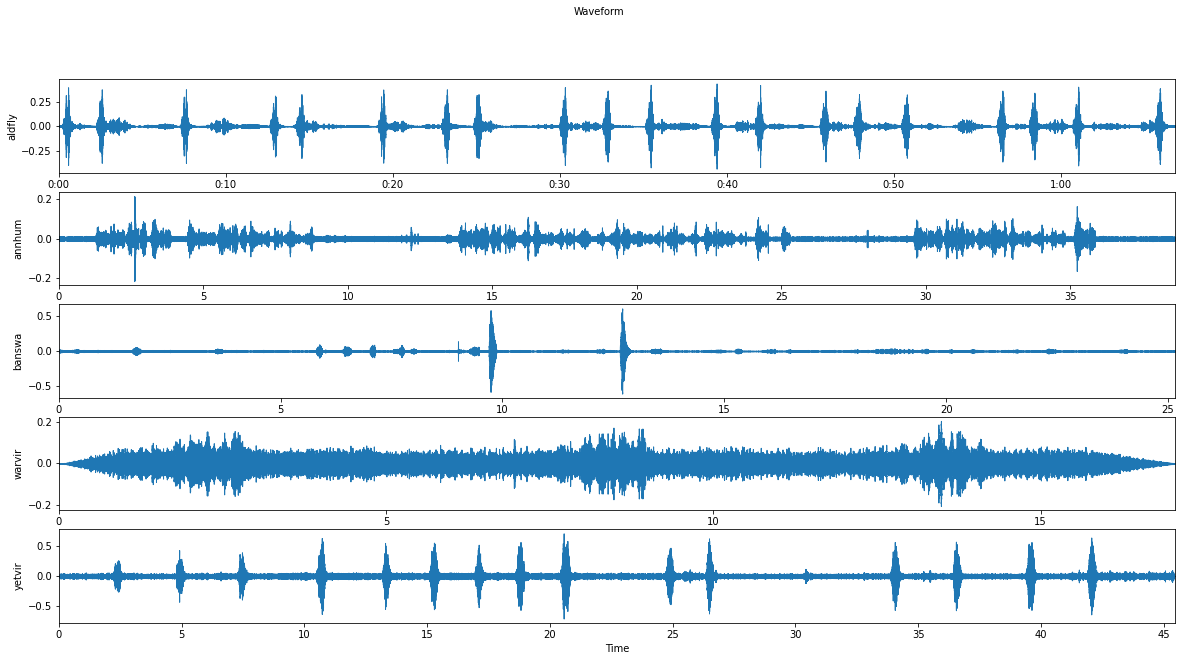

In [9]:
fig, ax = plt.subplots(5, figsize = (20, 10))
fig.suptitle('Waveform', fontsize=10)
librosa.display.waveplot(y = audio_aldfly, sr = sr_aldfly, ax=ax[0])
librosa.display.waveplot(y = audio_annhum, sr = sr_annhum, ax=ax[1])
librosa.display.waveplot(y = audio_banswa, sr = sr_banswa, ax=ax[2])
librosa.display.waveplot(y = audio_warvir, sr = sr_warvir, ax=ax[3])
librosa.display.waveplot(y = audio_yetvir, sr = sr_yetvir, ax=ax[4]);
for i, name in zip(range(5), birdlist):
    ax[i].set_ylabel(name, fontsize=10)

Text(0, 0.5, 'Magnitude')

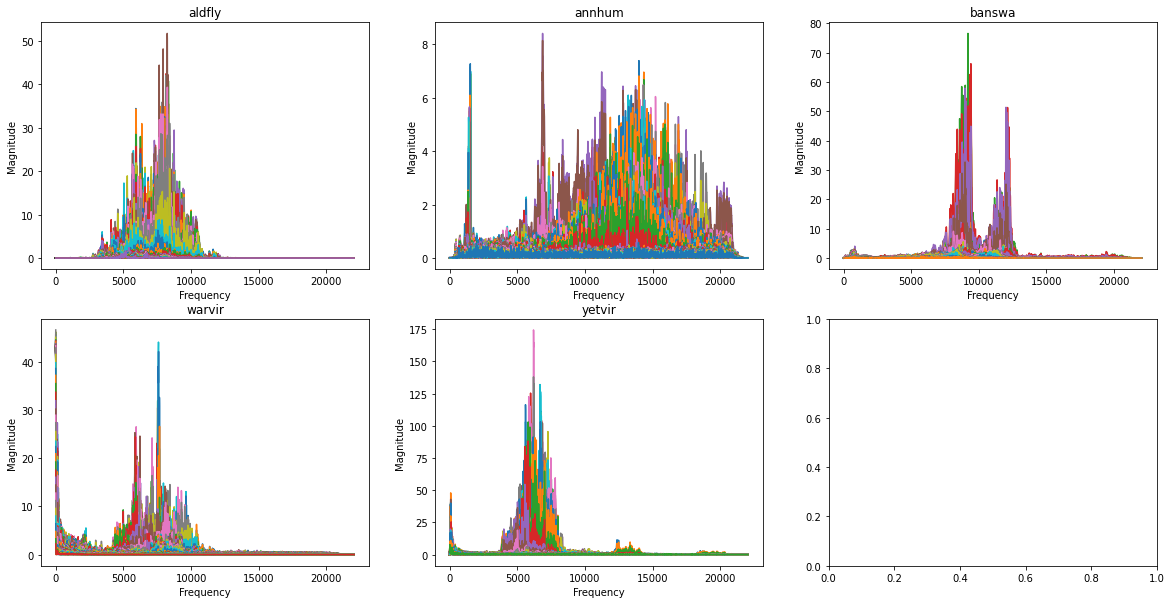

In [10]:
fig, ax = plt.subplots(2, 3, figsize=(20,10))
# Short-time Fourier transform (STFT)
Magnitude_aldfly = np.abs(librosa.stft(audio_aldfly, n_fft = 5515, hop_length = 1064))
Frequency_aldfly = np.linspace(0,sr_aldfly,len(Magnitude_aldfly))
plt.subplot(231)
plt.plot(Frequency_aldfly,Magnitude_aldfly)
plt.title('aldfly')
plt.xlabel("Frequency")
plt.ylabel("Magnitude")

Magnitude_annhum = np.abs(librosa.stft(audio_annhum, n_fft = 5515, hop_length = 1064))
Frequency_annhum = np.linspace(0,sr_annhum,len(Magnitude_annhum))
plt.subplot(232)
plt.plot(Frequency_annhum,Magnitude_annhum)
plt.title('annhum')
plt.xlabel("Frequency")
plt.ylabel("Magnitude")

Magnitude_banswa = np.abs(librosa.stft(audio_banswa, n_fft = 5515, hop_length = 1064))
Frequency_banswa = np.linspace(0,sr_banswa,len(Magnitude_banswa))
plt.subplot(233)
plt.plot(Frequency_banswa,Magnitude_banswa)
plt.title('banswa')
plt.xlabel("Frequency")
plt.ylabel("Magnitude")

Magnitude_warvir = np.abs(librosa.stft(audio_warvir, n_fft = 5515, hop_length = 1064))
Frequency_warvir = np.linspace(0,sr_warvir,len(Magnitude_warvir))
plt.subplot(234)
plt.plot(Frequency_warvir,Magnitude_warvir)
plt.title('warvir')
plt.xlabel("Frequency")
plt.ylabel("Magnitude")

Magnitude_yetvir = np.abs(librosa.stft(audio_yetvir, n_fft = 5515, hop_length = 1064))
Frequency_yetvir = np.linspace(0,sr_yetvir,len(Magnitude_yetvir))
plt.subplot(235)
plt.plot(Frequency_yetvir,Magnitude_yetvir)
plt.title('yetvir')
plt.xlabel("Frequency")
plt.ylabel("Magnitude")

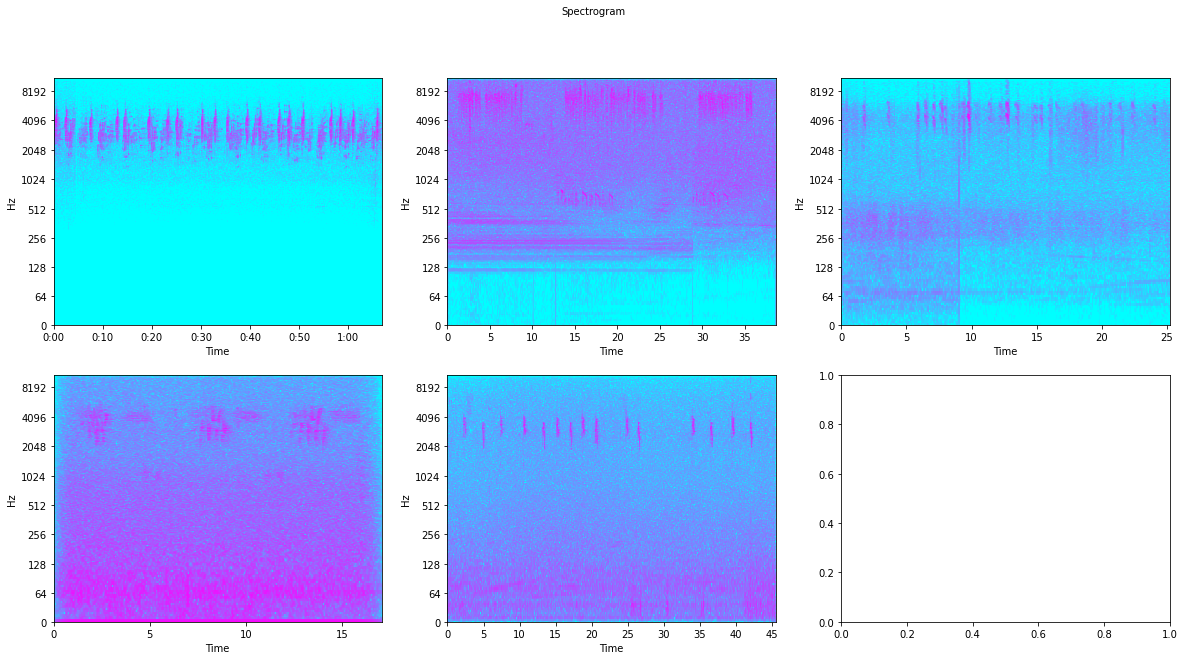

In [11]:
# Amplitude spectrogram to Decibels-scaled spectrogram
DB_aldfly = librosa.amplitude_to_db(Magnitude_aldfly, ref = np.max)
DB_annhum = librosa.amplitude_to_db(Magnitude_annhum, ref = np.max)
DB_banswa = librosa.amplitude_to_db(Magnitude_banswa, ref = np.max)
DB_warvir = librosa.amplitude_to_db(Magnitude_warvir, ref = np.max)
DB_yetvir = librosa.amplitude_to_db(Magnitude_yetvir, ref = np.max)
fig, ax = plt.subplots(2, 3, figsize=(20, 10))
fig.suptitle('Spectrogram', fontsize=10)
librosa.display.specshow(DB_aldfly, sr = sr_aldfly, hop_length = 1064, x_axis = 'time', y_axis = 'log', 
                         cmap = 'cool', ax=ax[0, 0])
librosa.display.specshow(DB_annhum, sr = sr_annhum, hop_length = 1064, x_axis = 'time', y_axis = 'log',
                         cmap = 'cool', ax=ax[0, 1])
librosa.display.specshow(DB_banswa, sr = sr_banswa, hop_length = 1064, x_axis = 'time', y_axis = 'log', 
                         cmap = 'cool', ax=ax[0, 2])
librosa.display.specshow(DB_warvir, sr = sr_warvir, hop_length = 1064, x_axis = 'time', y_axis = 'log', 
                         cmap = 'cool', ax=ax[1, 0])
librosa.display.specshow(DB_yetvir, sr = sr_yetvir, hop_length = 1064, x_axis = 'time', y_axis = 'log',
                         cmap = 'cool', ax=ax[1, 1]);

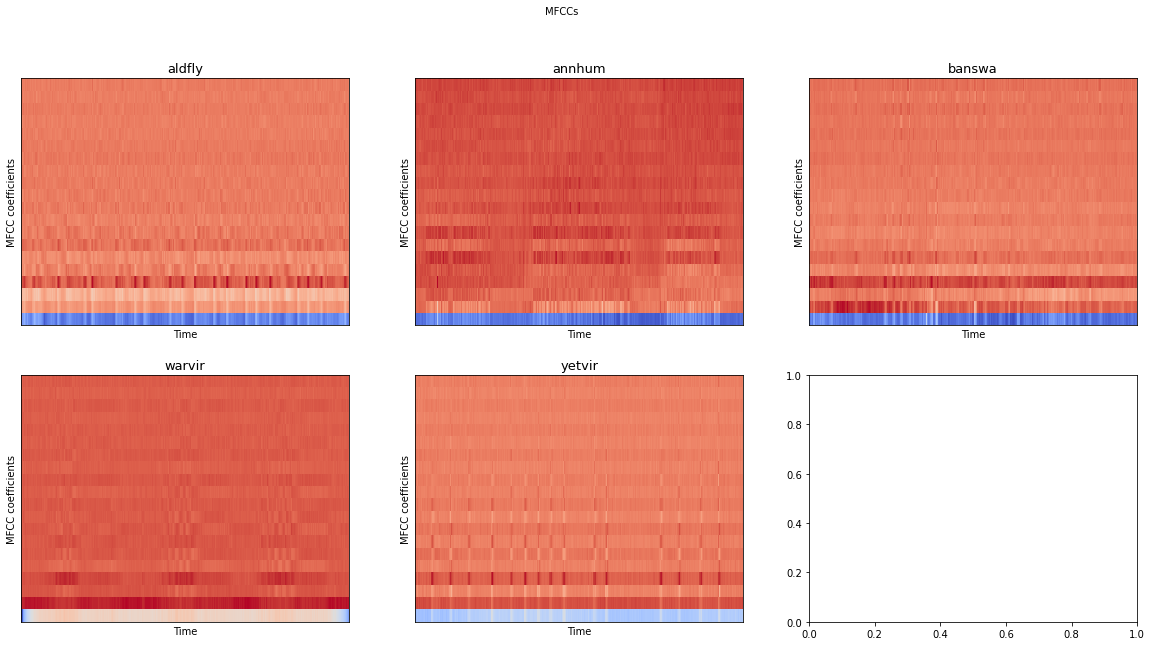

In [12]:
MFCCs_aldfly = librosa.feature.mfcc(audio_aldfly)
MFCCs_annhum = librosa.feature.mfcc(audio_annhum)
MFCCs_banswa = librosa.feature.mfcc(audio_banswa)
MFCCs_warvir = librosa.feature.mfcc(audio_warvir)
MFCCs_yetvir = librosa.feature.mfcc(audio_yetvir)
fig, ax = plt.subplots(2, 3, figsize=(20,10))
fig.suptitle('MFCCs', fontsize=10)
librosa.display.specshow(MFCCs_aldfly, sr=sr_aldfly, ax=ax[0, 0])
librosa.display.specshow(MFCCs_annhum, sr=sr_annhum, ax=ax[0, 1])
librosa.display.specshow(MFCCs_banswa, sr=sr_banswa, ax=ax[0, 2])
librosa.display.specshow(MFCCs_warvir, sr=sr_warvir, ax=ax[1, 0])
librosa.display.specshow(MFCCs_yetvir, sr=sr_yetvir, ax=ax[1, 1])
for i, name in zip(range(0, 2*3), birdlist):
    x = i // 3
    y = i % 3
    ax[x, y].set_title(name, fontsize=13)
    ax[x, y].set_xlabel('Time')
    ax[x, y].set_ylabel('MFCC coefficients')

In [13]:
def load_data(data_path,data_type):
    with open(data_path, "r") as fp:
        data = json.load(fp)
    X = np.array(data[data_type])
    y = np.array(data["labels"])
    values = list(set(y))
    for i in range(len(values)):
        y[y == values[i]] = i
    return  X, y 

In [14]:
def prepare_datasets(dataset, test_size, validation_size):
    if (dataset == "MFCC"):
        X, y = load_data(DATA_PATH_MFCC,"mfcc")
    if (dataset == "STFT"):
        X, y = load_data(DATA_PATH_STFT,"stft")    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)
    return X_train, X_validation, X_test, y_train, y_validation, y_test

In [15]:
DATA_PATH_STFT = "../input/jsoninputs/Birdcall_inputs/STFT.json"
DATA_PATH_MFCC = "../input/jsoninputs/Birdcall_inputs/MFCC.json"

In [16]:
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets("MFCC", 0.33, 0.2)
X2_train, X2_validation, X2_test, y2_train, y2_validation, y2_test = prepare_datasets("STFT", 0.33, 0.2)

In [17]:
bird_labels = ["aldfly", "annhum","banswa","warvir","yetvir"]
output_shape = len(bird_labels)

In [18]:
""""from sklearn.metrics import classification_report, confusion_matrix
cf=(confusion_matrix(validation_img.classes,y_pred1))
print(classification_report(validation_img.classes,y_pred1,target_names=labels))"""

'"from sklearn.metrics import classification_report, confusion_matrix\ncf=(confusion_matrix(validation_img.classes,y_pred1))\nprint(classification_report(validation_img.classes,y_pred1,target_names=labels))'

RNN-LSTM

In [19]:
def RNN_LSTM_model(input_shape, output_shape):
    model = keras.Sequential()
    model.add(keras.layers.LSTM(256, input_shape=input_shape, return_sequences=True))
    model.add(keras.layers.LSTM(128, dropout = 0.1))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.01))
    model.add(keras.layers.Dense(output_shape, activation='softmax'))
    return model

In [20]:
input_shape = (X_train.shape[1], X_train.shape[2])
model_RNN_LSTM = RNN_LSTM_model(input_shape, output_shape)
optimiser = keras.optimizers.Adam(learning_rate=0.001)
model_RNN_LSTM.compile(optimizer=optimiser,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model_RNN_LSTM.summary()
RNN_LSTM = model_RNN_LSTM.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=50)
test_loss, test_acc = model_RNN_LSTM.evaluate(X_test, y_test, verbose=2)
print('Test accuracy :', test_acc)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 259, 256)          276480    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 482,181
Trainable params: 482,181
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
77/77 [==============================] - 12s 50ms/step - loss: 1.4010 - accuracy: 0.3874 - val_loss: 0.95

In [21]:
y_pred = model_RNN_LSTM.predict(X_test)
y_pred

array([[2.3574678e-02, 9.7042251e-01, 4.3818691e-05, 6.6539294e-05,
        5.8924700e-03],
       [1.2437402e-05, 9.9994218e-01, 5.0861213e-06, 2.7577405e-05,
        1.2768290e-05],
       [4.5214619e-09, 9.6157109e-08, 5.1137562e-08, 9.9999940e-01,
        4.9068120e-07],
       ...,
       [7.1352917e-01, 6.0583989e-04, 2.2134162e-03, 2.8166261e-01,
        1.9889530e-03],
       [5.5789383e-04, 9.9889404e-01, 1.5207835e-05, 2.4014917e-05,
        5.0889276e-04],
       [3.8143030e-06, 1.0726710e-04, 9.9984229e-01, 3.1594375e-06,
        4.3420710e-05]], dtype=float32)

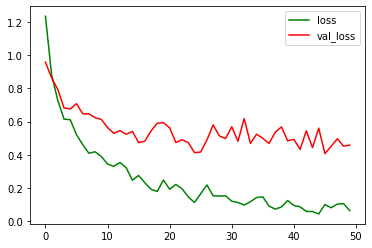

In [22]:
RNN_history=RNN_LSTM.history
RNN_loss=RNN_history['loss']
RNN_val_loss=RNN_history['val_loss']
plt.plot(RNN_loss,label="loss",markersize=2.2,color='green')
plt.plot(RNN_val_loss,label='val_loss',markersize=2.2,color='red')
plt.legend()
plt.show()

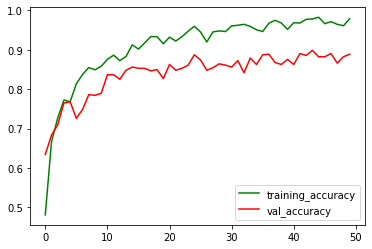

In [23]:
RNN_acc=RNN_history['accuracy']
RNN_val_acc=RNN_history['val_accuracy']
plt.plot(RNN_acc,label="training_accuracy",markersize=2.2,color='green')
plt.plot(RNN_val_acc,label='val_accuracy',markersize=2.2,color='red')
plt.legend()
plt.show()

In [24]:
output_RNN_LSTM = np.argmax(y_pred, axis = 1)
output_RNN_LSTM

array([1, 1, 3, ..., 0, 1, 2])

In [25]:
#cf=(confusion_matrix(y_test, output_RNN_LSTM))
#print(classification_report(y_test, output_RNN_LSTM,target_names=bird_labels))

In [26]:
#print(cf)

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from sklearn import metrics

In [28]:
def add_axis(X_train, X_validation, X_test):  
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]
    
    return X_train, X_validation, X_test

In [29]:
### Add new axis to inputs for CNN ###
X_train_new, X_validation_new, X_test_new = add_axis(X_train, X_validation, X_test)
X2_train_new, X2_validation_new, X2_test_new = add_axis(X2_train, X2_validation, X2_test)

In [30]:
def build_model_conv(input_shape, output_shape):
    model = keras.Sequential()
    
    # 1st layer
    model.add(keras.layers.Conv2D(64, (4, 4), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd layer
    model.add(keras.layers.Conv2D(16, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    
    # 4th layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.5))

    # output layer
    model.add(keras.layers.Dense(output_shape, activation='softmax'))

    return model

In [31]:
input_shape = (X_train_new.shape[1], X_train_new.shape[2], 1)
model_conv = build_model_conv(input_shape, output_shape)
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model_conv.compile(optimizer=optimiser,
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])
model_conv.summary()
conv = model_conv.fit(X_train_new, y_train, validation_data=(X_validation_new, y_validation), batch_size=32, epochs=80)
test_loss_conv, test_acc_conv = model_conv.evaluate(X_test_new, y_test, verbose=2)
print('Test accuracy :', test_acc_conv)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 10, 64)       1088      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 5, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 5, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 126, 3, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 2, 32)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 63, 2, 32)         128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 1, 16)        

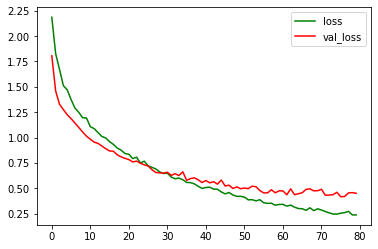

In [32]:
CNN_history=conv.history
CNN_loss=CNN_history['loss']
CNN_val_loss=CNN_history['val_loss']
plt.plot(CNN_loss,label="loss",markersize=2.2,color='green')
plt.plot(CNN_val_loss,label='val_loss',markersize=2.2,color='red')
plt.legend()
plt.show()

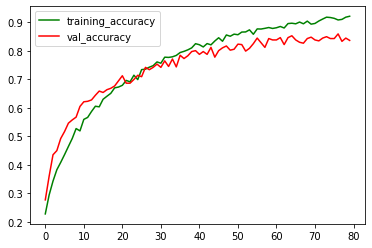

In [33]:
CNN_acc=CNN_history['accuracy']
CNN_val_acc=CNN_history['val_accuracy']
plt.plot(CNN_acc,label="training_accuracy",markersize=2.2,color='green')
plt.plot(CNN_val_acc,label='val_accuracy',markersize=2.2,color='red')
plt.legend()
plt.show()

In [34]:
y_pred2 = model_conv.predict(X_test_new)

In [35]:
output_CNN = np.argmax(y_pred2, axis = 1)
output_CNN

array([1, 1, 3, ..., 3, 1, 2])

In [36]:
cf_CNN=(confusion_matrix(y_test, output_CNN))
print(classification_report(y_test, output_CNN,target_names=bird_labels))

NameError: name 'classification_report' is not defined

In [ ]:
print(cf_CNN)

In [ ]:
def get_ANN(input_shape, output_shape):
    model=keras.Sequential()
    # input layer
    model.add(keras.layers.Flatten(input_shape=input_shape))
    # 1st dense layer
    model.add(keras.layers.Dense(512, activation='relu', kernel_initializer = 'glorot_uniform'))

    # 2nd dense layer
    model.add(keras.layers.Dense(256, activation='relu'))
    
    # 3rd dense layer
    model.add(keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
    model.add(keras.layers.Dropout(0.2))
        
    # 4th dense layer
    model.add(keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
    model.add(keras.layers.Dropout(0.3))
    
    # 5th dense layer
    model.add(keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
    
    # 6th dense layer
    model.add(keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
        
    # output layer
    model.add(keras.layers.Dense(output_shape, activation='softmax'))
    return model

In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2])
model_ann = get_ANN(input_shape, output_shape)
optimiser = keras.optimizers.Adam(learning_rate=0.01)
model_ann.compile(optimizer='Adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])
model_ann.summary()
ann = model_ann.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=80)
test_loss_ann, test_acc_ann = model_ann.evaluate(X_test, y_test, verbose=2)
print('Test accuracy :', test_acc_ann)

In [ ]:
ANN_history=ann.history
ANN_loss=ANN_history['loss']
ANN_val_loss=ANN_history['val_loss']
plt.plot(ANN_loss,label="loss",markersize=2.2,color='green')
plt.plot(ANN_val_loss,label='val_loss',markersize=2.2,color='red')
plt.legend()
plt.show()

In [ ]:
ANN_acc=ANN_history['accuracy']
ANN_val_acc=ANN_history['val_accuracy']
plt.plot(ANN_acc,label="training_accuracy",markersize=2.2,color='green')
plt.plot(ANN_val_acc,label='val_accuracy',markersize=2.2,color='red')
plt.legend()
plt.show()

In [ ]:
y_pred1 = model_ann.predict(X_test)

In [ ]:
output_ANN = np.argmax(y_pred1, axis = 1)
output_ANN

In [ ]:
cf=(confusion_matrix(y_test, output_ANN))
print(classification_report(y_test, output_ANN,target_names=bird_labels))

In [ ]:
print(cf)

In [ ]:
"""    %matplotlib inline
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.utils import plot_model
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    import numpy as np

In [ ]:
"""plot_model(model_ann, to_file='model_ann.png', show_shapes=True, show_layer_names=True)
img = mpimg.imread('model_ann.png')
plt.figure(figsize=(100,70))
imgplot = plt.imshow(img)

In [ ]:
"""plot_model(model_conv, to_file='model_cnn.png', show_shapes=True, show_layer_names=True)
img = mpimg.imread('model_cnn.png')
plt.figure(figsize=(50,30))
imgplot = plt.imshow(img)

In [ ]:
"""plot_model(model_RNN_LSTM, to_file='model_RNN_LSTM.png', show_shapes=True, show_layer_names=True)
img = mpimg.imread('model_RNN_LSTM.png')
plt.figure(figsize=(50,30))
imgplot = plt.imshow(img)"""